# Notebook 2: Exploratory Data Analysis & Feature Selection

## Objectives

* Explore the heart disease dataset to identify patterns and relationships between features and the target variable.
* Determine the top features to feed into machine learning models.

## Inputs
* `outputs/datasets/collection/heart_disease_raw.csv` (from Notebook 1)

## Outputs
* Insights and visualizations to guide feature selection.
* List of top candidate variables for modeling.
* Optional figures saved to `outputs/figures`.

### OPTIONAL: Automated Profiling Report
Uncomment to run this for a quick, minimal summary of the dataset.

from ydata_profiling import ProfileReport
import pandas as pd
data_path = "outputs/datasets/collection/heart_disease_raw.csv"
df = pd.read_csv(data_path)
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

---

Load raw dataset as way to verify that we are loading the correct dataset

In [1]:
import pandas as pd
df = pd.read_csv("/workspaces/Heart_disease_risk_predictor/inputs/datasets/raw/heart_disease_uci.csv")

# Show first 5 rows
print("Dataset loaded successfully! First 5 rows of dataset:")
display(df.head())

Dataset loaded successfully! First 5 rows of dataset:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Target Variable Distribution for "num" indicating stage of the heart disease

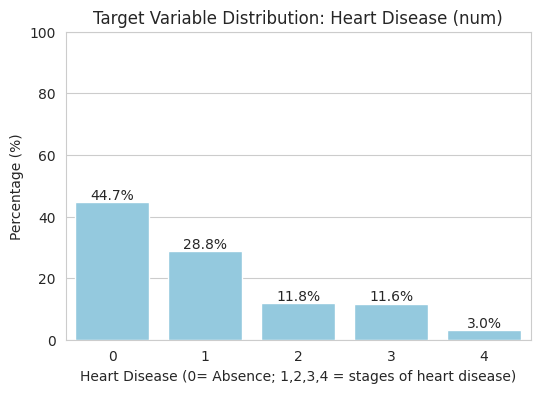

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Calculate percentage distribution
target_percent = df["num"].value_counts(normalize=True) * 100
target_labels = target_percent.index

plt.figure(figsize=(6,4))
sns.barplot(x=target_labels, y=target_percent.values, color="skyblue")

plt.title("Target Variable Distribution: Heart Disease (num)")
plt.xlabel("Heart Disease (0= Absence; 1,2,3,4 = stages of heart disease)")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)  # Ensures y-axis goes from 0 to 100

# Optionally, annotate the bars with the exact percentages
for i, pct in enumerate(target_percent.values):
    plt.text(i, pct + 1, f'{pct:.1f}%', ha='center')

plt.show()


Numerical Features Distribution

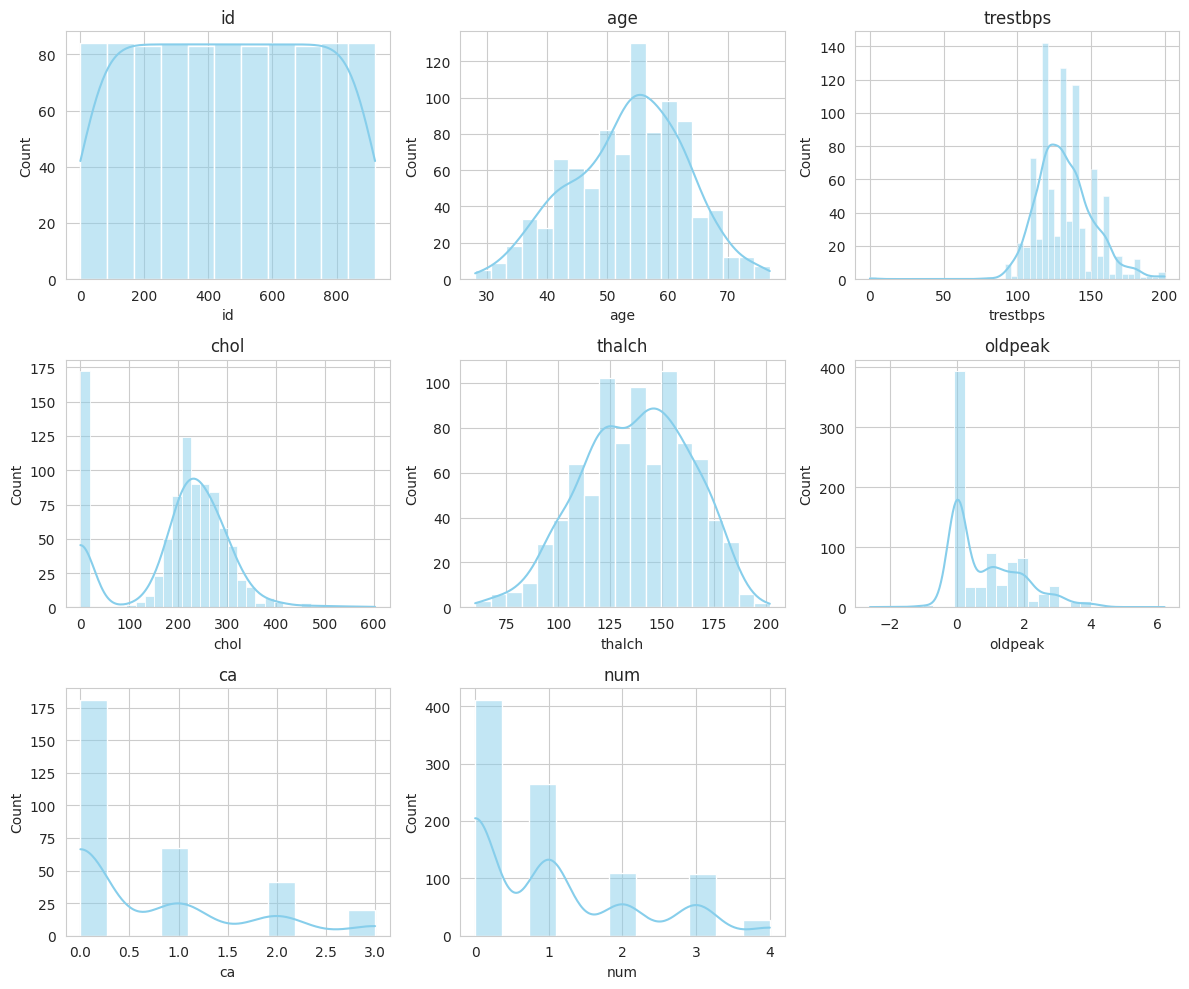

In [3]:
numerical_vars = df.select_dtypes(include='number').columns.tolist()
# numerical_vars.remove('num')  # Exclude target

plt.figure(figsize=(12,10))
for i, col in enumerate(numerical_vars, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, color="skyblue")
    plt.title(col)
plt.tight_layout()
plt.show()

Identify categorical variables and inspect category counts

In [15]:
categorical_vars = df.select_dtypes(include='object').columns.tolist()

for col in categorical_vars:
    print(f"--- {col} ---")
    print(f"Unique values: {df[col].nunique()}")
    print(df[col].value_counts().head(5))  # Top 5 most frequent
    print("\n")

--- sex ---
Unique values: 2
sex
Male      726
Female    194
Name: count, dtype: int64


--- dataset ---
Unique values: 4
dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64


--- cp ---
Unique values: 4
cp
asymptomatic       496
non-anginal        204
atypical angina    174
typical angina      46
Name: count, dtype: int64


--- fbs ---
Unique values: 2
fbs
False    692
True     138
Name: count, dtype: int64


--- restecg ---
Unique values: 3
restecg
normal              551
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64


--- exang ---
Unique values: 2
exang
False    528
True     337
Name: count, dtype: int64


--- slope ---
Unique values: 3
slope
flat           345
upsloping      203
downsloping     63
Name: count, dtype: int64


--- thal ---
Unique values: 3
thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64




Let's calculate the percentage of heart disease cases within each gender group,
accounting for the fact that the dataset is imbalanced between males and females.

In [16]:
if 'sex' in df.columns:
    sex_disease_percentage = (
        df.groupby('sex')['num']
        .value_counts(normalize=True)
        .mul(100)
        .rename('percentage')
        .reset_index()
    )
    print("Heart Disease Percentage by Gender:")
    print(sex_disease_percentage)

Heart Disease Percentage by Gender:
      sex  num  percentage
0  Female    0   74.226804
1  Female    1   15.463918
2  Female    2    5.154639
3  Female    3    4.123711
4  Female    4    1.030928
5    Male    0   36.776860
6    Male    1   32.369146
7    Male    2   13.636364
8    Male    3   13.636364
9    Male    4    3.581267


Categorical Features Distribution

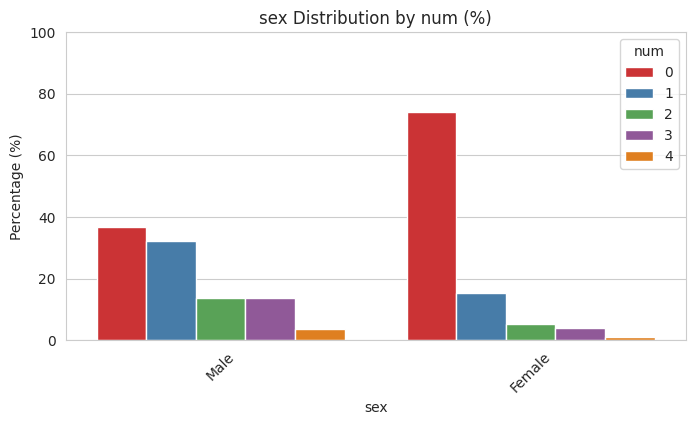

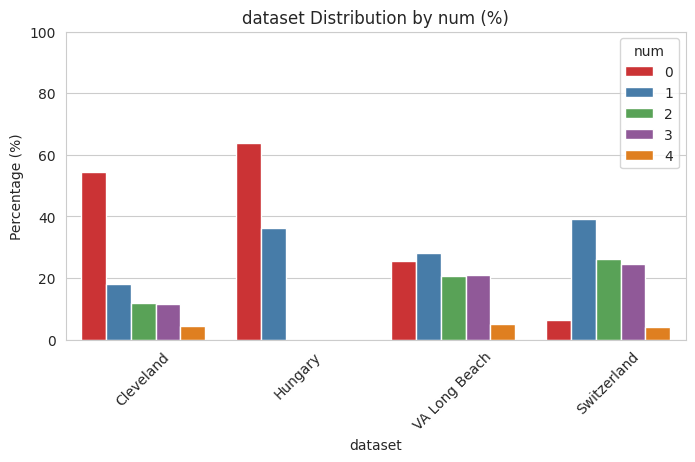

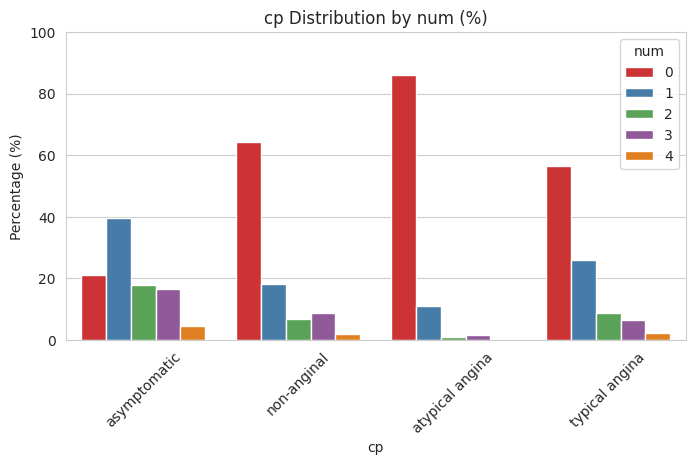

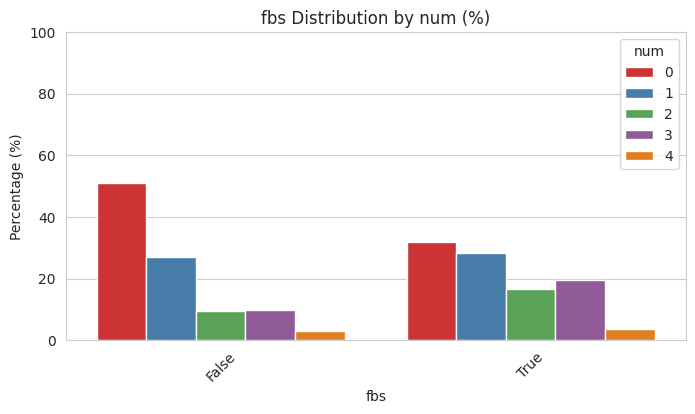

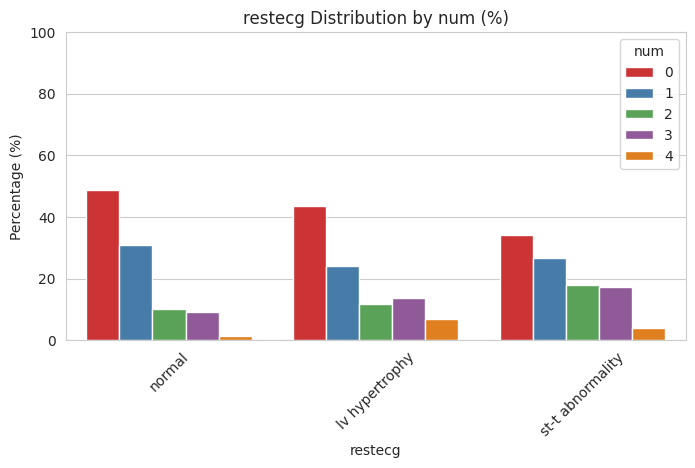

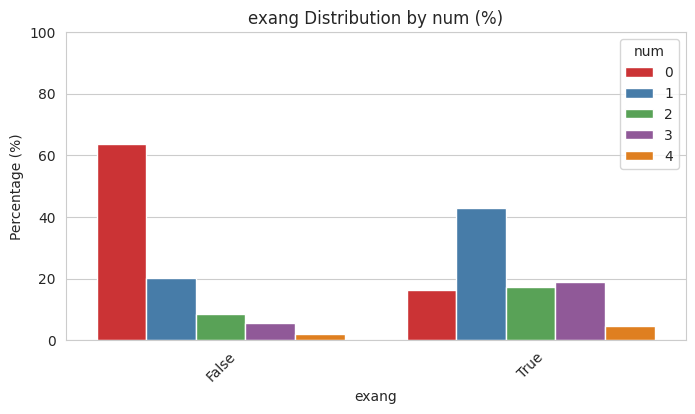

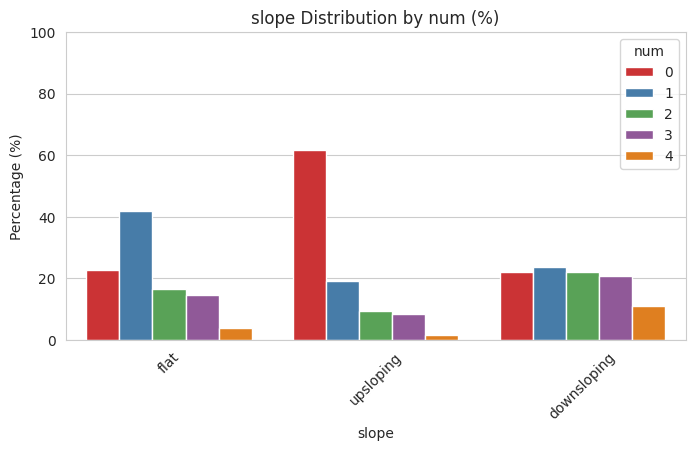

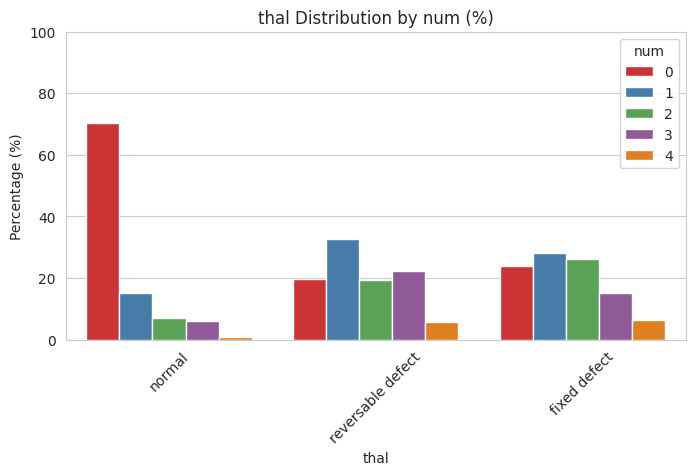

In [17]:
categorical_vars = df.select_dtypes(include='object').columns.tolist()

def plot_categorical_percent(df, col, target="num"):
    plt.figure(figsize=(8,4))
    
    # Calculate percentages within each category
    cat_percentages = (
        df.groupby(col)[target]
        .value_counts(normalize=True)  # relative to each category
        .mul(100)
        .rename("percentage")
        .reset_index()
    )
    
    sns.barplot(
        data=cat_percentages,
        x=col, y="percentage",
        hue=target,
        palette="Set1",
        order=df[col].value_counts().index
    )
    
    plt.xticks(rotation=45)
    plt.ylabel("Percentage (%)")
    plt.title(f"{col} Distribution by {target} (%)")
    plt.ylim(0, 100)
    plt.show()

# Loop through and plot
for col in categorical_vars:
    if df[col].nunique() <= 15:  # Avoid overly cluttered plots
        plot_categorical_percent(df, col)


Correlation Analysis

Spearman correlation

In [8]:
numeric_cols = df.select_dtypes(include='number')
corr_spearman = numeric_cols.corr(method='spearman')['num'].sort_values(key=abs, ascending=False)[1:]
print("Top correlations with target (Spearman):")
display(corr_spearman.head(10))

corr_pearson = numeric_cols.corr(method='pearson')['num'].sort_values(key=abs, ascending=False)[1:]
print("Top correlations with target (Pearson):")
display(corr_pearson.head(10))




Top correlations with target (Spearman):


ca          0.528047
oldpeak     0.434273
thalch     -0.398360
age         0.347184
id          0.325659
chol       -0.157563
trestbps    0.126805
Name: num, dtype: float64

Top correlations with target (Pearson):


ca          0.516216
oldpeak     0.443084
thalch     -0.366265
age         0.339596
id          0.273552
chol       -0.231547
trestbps    0.122291
Name: num, dtype: float64

Feature Selection for Modeling


In [9]:
top_features = list(set(corr_spearman.head(5).index.to_list() + corr_pearson.head(5).index.to_list()))
print("Candidate features for modeling:")
print(top_features)

Candidate features for modeling:
['thalch', 'ca', 'age', 'id', 'oldpeak']


Optional: Pairplot / Multi-dimensional Visualization

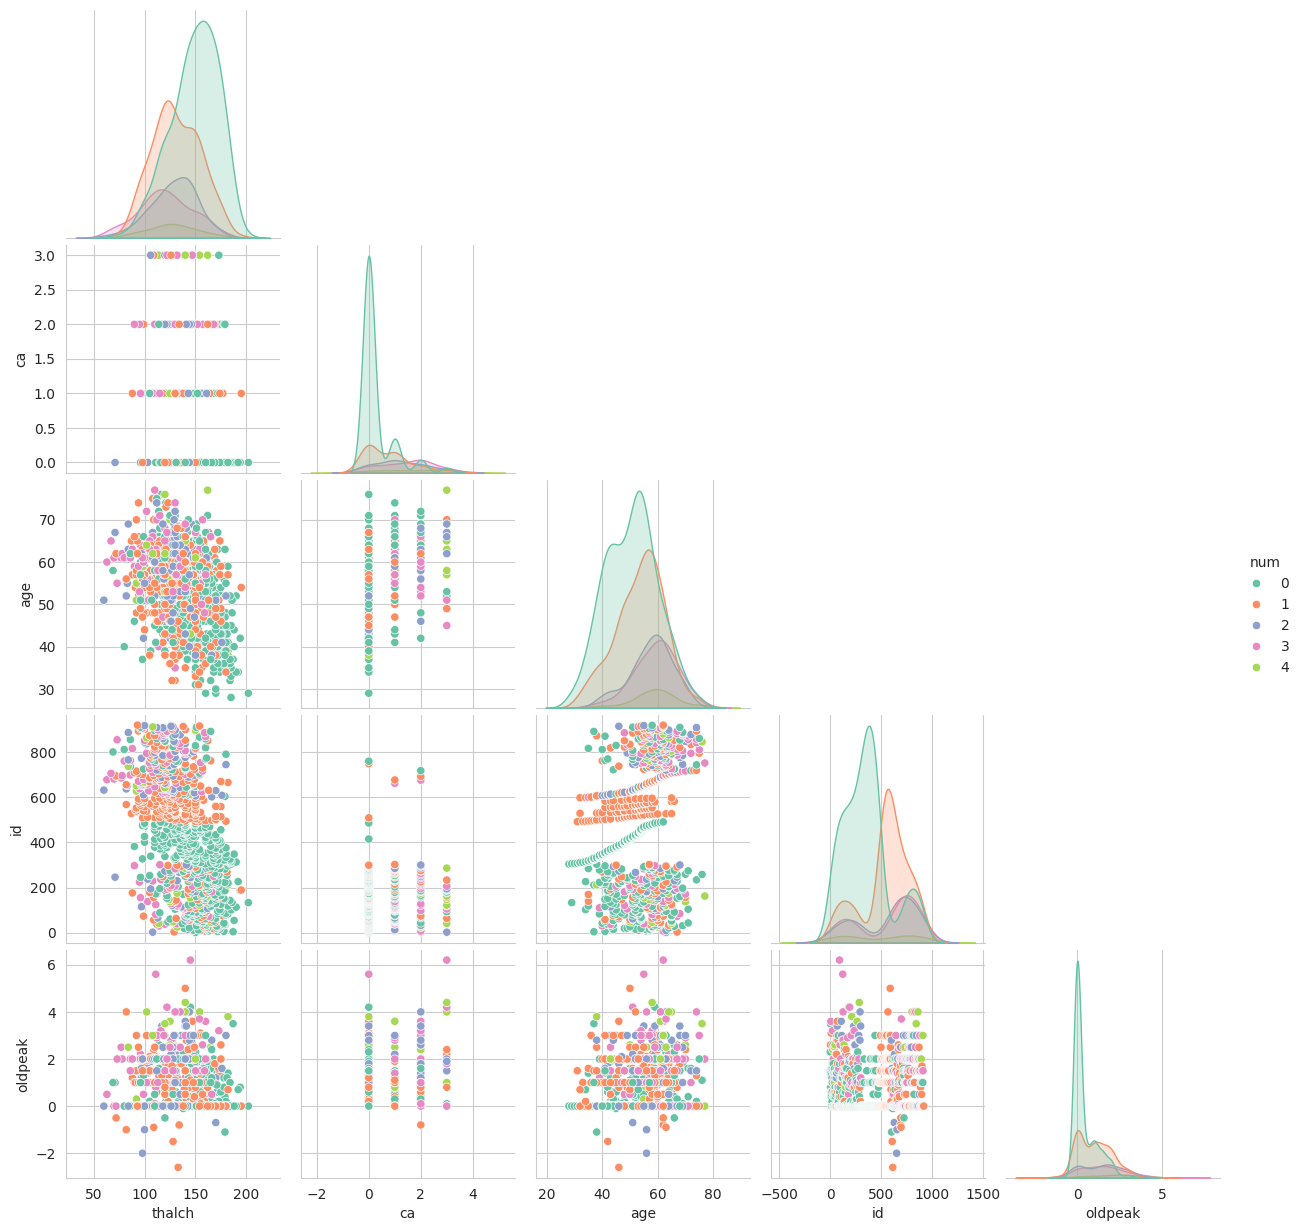

In [10]:
sns.pairplot(df[top_features + ['num']], hue='num', corner=True, palette="Set2")
plt.show()

In [12]:
df[col].nunique()

df[col].value_counts().head(20)

thal
normal               196
reversable defect    192
fixed defect          46
Name: count, dtype: int64